<a href="https://colab.research.google.com/github/irfanrasheedkc/Potato-disease-classifier/blob/main/Preprocessing%20in%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato-disease-classifier/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
# fig, axes = plt.subplots(3, 4, figsize=(10, 10))

# for i, ax in enumerate(axes.flat):
#     ax.imshow(image_batch[i].numpy().astype("uint8"))
#     ax.set_title(class_names[label_batch[i]])
#     ax.axis('off')


In [8]:
def get_dataset_partition_tf(ds , train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle=True , shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [9]:
train_ds , val_ds , test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(val_ds)

6

In [12]:
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 10s 146ms/step - loss: 0.9073 - accuracy: 0.5093 - val_loss: 0.8890 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 3s 57ms/step - loss: 0.7021 - accuracy: 0.6956 - val_loss: 0.5834 - val_accuracy: 0.6615
Epoch 3/50
54/54 [==============================] - 3s 56ms/step - loss: 0.4369 - accuracy: 0.8108 - val_loss: 0.4332 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 3s 58ms/step - loss: 0.2742 - accuracy: 0.8837 - val_loss: 0.2993 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 3s 57ms/step - loss: 0.1955 - accuracy: 0.9265 - val_loss: 0.1682 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 3s 56ms/step - loss: 0.2240 - accuracy: 0.9080 - val_loss: 0.2025 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 3s 59ms/step - loss: 0.1135 - accuracy: 0.9531 - val_loss: 0.0858 - val_accuracy: 0.9583
Epoch 8/50


In [24]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 27ms/step - loss: 6.6453e-04 - accuracy: 1.0000


In [25]:
scores

[0.0006645297398790717, 1.0]

In [26]:
history


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])


list

In [30]:
len(history.history['loss'])


50

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.907333493232727,
 0.7020630836486816,
 0.4368921220302582,
 0.2741907835006714,
 0.1954658478498459]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

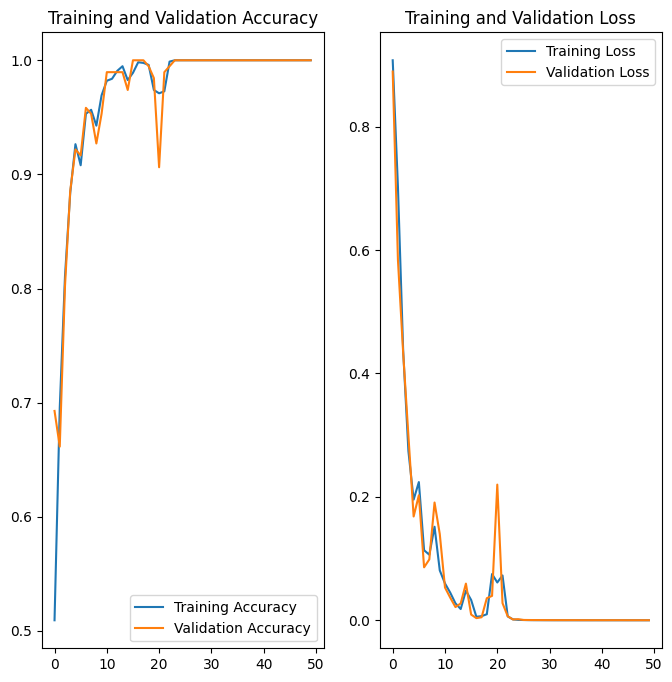

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
